# Reducción de la dimensionalidad

Consulta [A Tutorial on Principal Component Analysis](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf) para una decripción intuitiva y detallada de PCA y SVD

A continuación importamos todas las librerias y funciones necesarias para correr el notebook.

In [1]:
!wget https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv
!wget https://raw.githubusercontent.com/rramosp/20162.ai/master/data/mnist1.5k.csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import datasets
%matplotlib inline

--2019-11-29 16:41:42--  https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10889 (11K) [text/plain]
Saving to: ‘wine.csv’

wine.csv            100%[===================>]  10.63K  --.-KB/s    in 0s      

2019-11-29 16:41:42 (147 MB/s) - ‘wine.csv’ saved [10889/10889]

--2019-11-29 16:41:44--  https://raw.githubusercontent.com/rramosp/20162.ai/master/data/mnist1.5k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2744237 (2.6M) [tex

In [0]:
# Función para visualizar un conjunto de datos en 2D
def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")
    plt.title("Data")

## Intuición

A continuación presentamos los siguientes datos 2D y queremos encontrar una proyección en 1D que preserve la máxima cantidad de variabilidad.


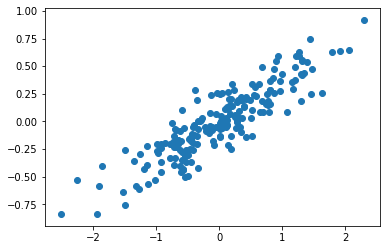

In [3]:
np.random.seed(1)
X = np.dot(np.random.random(size=(2, 2)), np.random.normal(size=(2, 200))).T+10

# Centra los datos en 0,0
X=X-np.mean(X, axis=0)

plt.scatter(X[:,0], X[:,1])

Recordemos que la proyección de un vector $\vec{x}$ en otro vector $\vec{v}$ (consulta [aquí](https://matthew-brett.github.io/teaching/vector_projection.html)) viene dada por:

$$c = \frac{\vec{v}\cdot \vec{x}}{||\vec{v}||^2}$$


$$proj_\vec{v} \vec{x} = \vec{v} c$$


donde $c$ es el tamaño de la proyección de  $\vec{x}$ sobre $\vec{v}$

### Vamos a inspeccionar algunas proyecciones

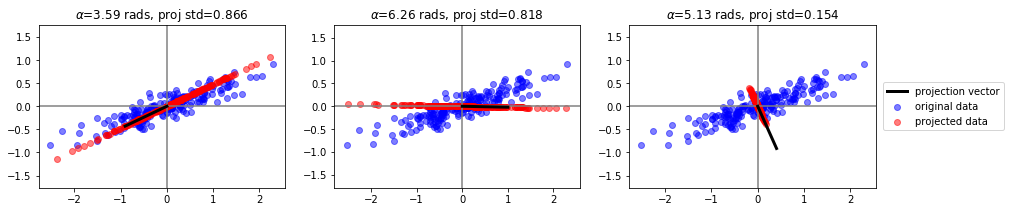

In [4]:
plt.figure(figsize=(15,3))

unit_vector = lambda angle: np.array([np.cos(angle), np.sin(angle)])

for i in range(3):
    plt.subplot(1,3,i+1)
    angle = np.random.random()*np.pi*2
    v = unit_vector(angle)

    c = X.dot(v.reshape(-1,1))/(np.linalg.norm(v)**2)
    Xp = np.repeat(v.reshape(-1,2),len(X),axis=0)*c

    plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
    plt.scatter(Xp[:,0], Xp[:,1], color="red", alpha=.5, label="projected data")
    plt.axvline(0, color="gray")
    plt.axhline(0, color="gray")
    plt.plot([0,v[0]], [0,v[1]], color="black", lw=3, label="projection vector")
    plt.axis('equal')
    plt.ylim(-2,2)
    plt.title("$\\alpha$=%.2f rads, proj std=%.3f"%(angle, np.std(c)))
    if i==2:
        plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

### Despues queremos encontrar las proyecciones con mayor y menor varianza por fuerza bruta

Text(0, 0.5, 'projection std')

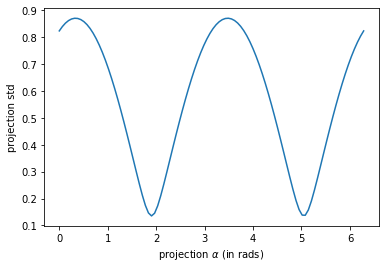

In [5]:
def get_maxmin_projections(X):
    stds = []
    angles = np.linspace(0,np.pi*2, 100)
    for a in angles:
        v = np.array([np.cos(a), np.sin(a)])
        c = X.dot(v.reshape(-1,1))/(np.linalg.norm(v)**2)
        stds.append(np.std(c))
    v2 = unit_vector(angles[np.argmin(stds)])
    v1 = unit_vector(angles[np.argmax(stds)])
    
    return angles, stds, v1, v2

angles, stds, v1, v2 = get_maxmin_projections(X)

plt.plot(angles, stds)
plt.xlabel("projection $\\alpha$ (in rads)")
plt.ylabel("projection std")

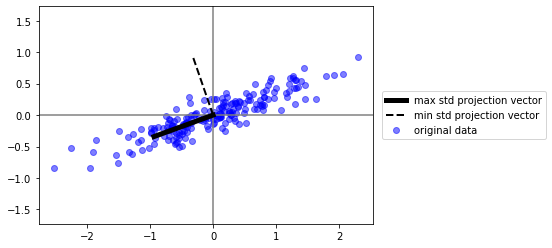

In [6]:
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
plt.axvline(0, color="gray")
plt.axhline(0, color="gray")
plt.plot([0,v1[0]], [0,v1[1]], color="black", lw=5, label="max std projection vector")
plt.plot([0,v2[0]], [0,v2[1]], color="black", ls="--", lw=2, label="min std projection vector")
plt.axis('equal')
plt.ylim(-2,2)
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

##Análisis de componentes principales

El análisis de componentes principales (en inglés PCA) es una técnica utilizada para describir un conjunto de datos en términos de nuevas variables ("componentes") no correlacionadas. Las componentes son ordenanadas por la cantidad de varianza original que describen, por lo que la técnica es útil para reducir la dimensionalidad de un conjunto de datos.

En otras palabras, la técnica PCA busca la proyección según la cual los datos queden mejor representados en términos de mínimos cuadrados. Es decir, convierte un conjunto de observaciones de variables posiblemente correlacionadas en un conjunto de valores de variables sin correlación lineal llamadas componentes principales. Esta técnica se emplea principalmente en el análisis exploratorio de datos y en la construcción de modelos predictivos.

**Limitaciones:**
  * Suposición de linealidad: Se asume que los datos observados son combinación lineal de una cierta base.
  * Importancia estadística de la media y la covarianza: PCA utiliza los vectores propios de la matriz de covarianzas y sólo encuentra las direcciones de ejes en el espacio de variables considerando que los datos se distribuyen de manera gaussiana.




Tomado de: https://es.wikipedia.org/wiki/An%C3%A1lisis_de_componentes_principales

![alt text](https://blog-c7ff.kxcdn.com/blog/wp-content/uploads/2018/07/pca.gif)

###Varianza explicada para las componentes principales

La varianza total es la suma de las varianzas de todos los componentes principales individuales.
Por lo tanto,  la fracción de varianza explicada por un componente principal es la relación entre la varianza de ese componente principal y la varianza total.
Por otro lado si se quiere conocer el porcentaje de varianza total de varios componentes principales; sume sus varianzas y divídalos por la varianza total.
Esta información se puede obtener con el atributo `explained_variance_ratio_`

 ![alt text](https://qph.fs.quoracdn.net/main-qimg-390d70c60aad66494186e4b9b288459f)

**Comparemos el análisis de componentes principales  con lo componentes obtenidos por fuerza bruta**.
**Podemos observar que la dimensionalidad es la misma que los datos originales**:



In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) 
pca.fit(X)
print("sklearn PCA components")
print(pca.components_)
print("brute force components")
print(v1)
print(v2)

sklearn PCA components
[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
brute force components
[-0.93969262 -0.34202014]
[-0.32706796  0.94500082]


Pero de modo mucho más eficiente

In [8]:
%timeit pca.fit(X)

The slowest run took 7.71 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 219 µs per loop


In [9]:
%timeit get_maxmin_projections(X)

100 loops, best of 3: 4.48 ms per loop


### Podemos usar el componente mayor para reducir la dimensionalidad de nuestros datos de 2D a 1D

Observa que:

$$\mathbf{X_t} = \mathbf{X} \cdot \mathbf{V}$$

donde:
- $\mathbf{X}$ son nuestros datos
- $\mathbf{V}$ es el vector de componentes seleccionados
- $\mathbf{X_t}$ son los datos transformados

así que nos estamos restringiendo a **transformaciones lineales** (rotaciones y escalado)


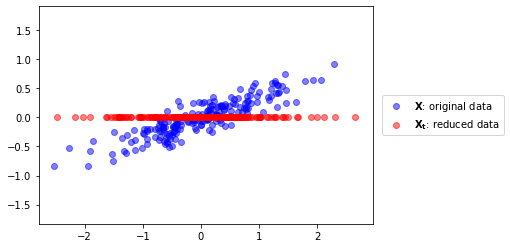

In [10]:
pca = PCA(n_components=1) 
pca.fit(X)
Xt = pca.transform(X)
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="$\mathbf{X}$: original data")
plt.scatter(Xt, [0]*len(Xt), color="red", alpha=.5, label="$\mathbf{X_t}$: reduced data")
plt.axis("equal");
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

Y podemos también reconstruir los datos 2D después de la transformación

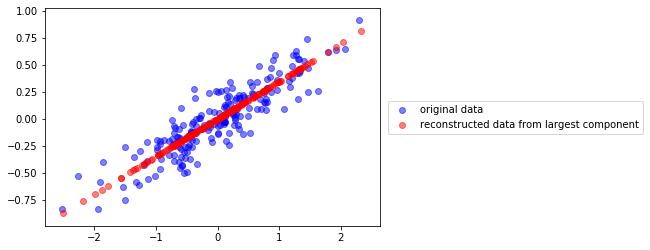

In [11]:
Xr = pca.inverse_transform(Xt)
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="original data")
plt.scatter(Xr[:,0], Xr[:,1], color="red", alpha=.5, label="reconstructed data from largest component")
plt.legend(loc="center left", bbox_to_anchor=(1.01,.5))

La varianza expicada se obtiene del atributo  `explained_variance_ratio_`:

In [12]:
pca = PCA(n_components=2) 
pca.fit(X)
pca.explained_variance_ratio_

array([0.97634101, 0.02365899])

El resultado indica que el primer componente explica el 97.6% de la varianza y el segundo componente el 2.4% restante.

## Ejemplo de PCA aplicado al conjunto de datos Wine

Primero cargamos el conjunto de datos wine, realizamos un escalado de los datos (media = 0 y varianza =1) y graficamos todas las características presentando las 3 clases de vino, como sigue:

In [13]:
wine_df = pd.read_csv('wine.csv')
wine_df.head()
labels = wine_df['Wine']
classes = wine_df['Wine'].unique()
print(classes)
wine_no_classes = wine_df.drop(columns='Wine').copy()
wine_no_classes.head()

[1 2 3]


,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [0]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_x.fit(wine_no_classes.values)
X_scaled = sc_x.transform(wine_no_classes.values)

In [15]:
X_scaled.shape

(178, 13)

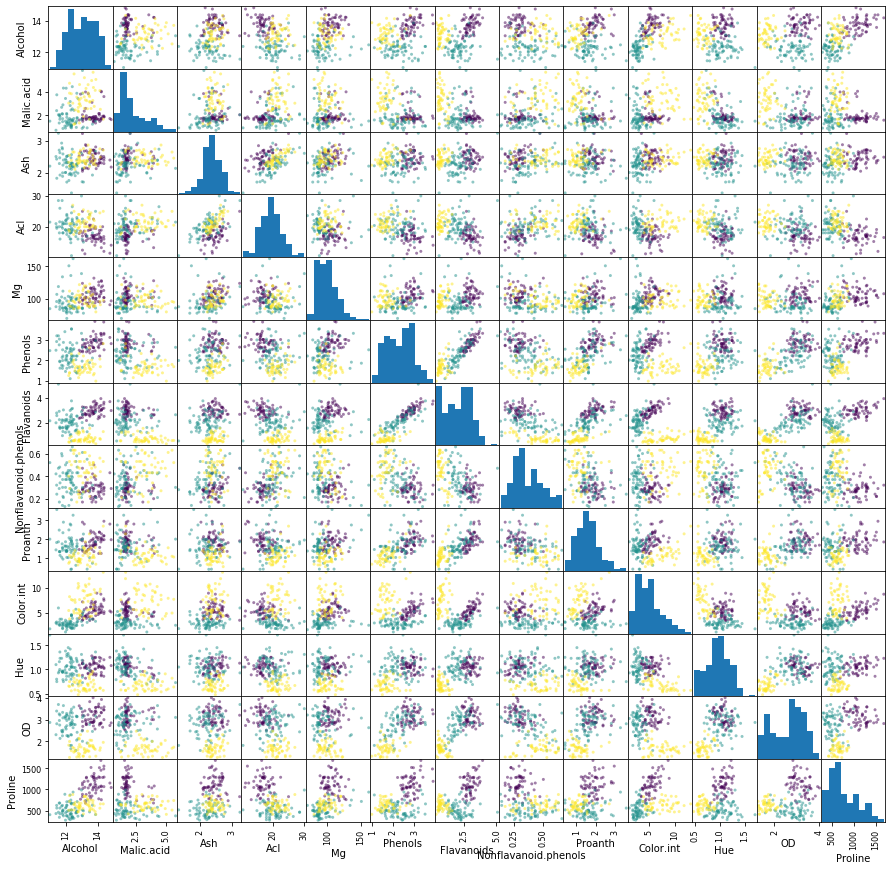

In [16]:
d = pd.plotting.scatter_matrix(wine_no_classes, c=wine_df.Wine,figsize=(15, 15))

Análizando la varianza explicada de las componentes principales obtenemos lo siguiente:

In [18]:
sklearn_pca = PCA(n_components=None)
sklearn_transf = sklearn_pca.fit_transform(X_scaled)
varianza_expl = sklearn_pca.explained_variance_ratio_
varianza_expl

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019,
       0.01736836, 0.01298233, 0.00795215])

A continuación graficamos la curva acumulativa de la varianza explicada versus el número de componentes principales, donde podemos observar lo siguiente:
  * Las componentes principales 1 y 2 representan el 55,4% de la varianza de los datos
  * Las 7 primeras componentes principales representan el 89,3% de la varianza de los datos

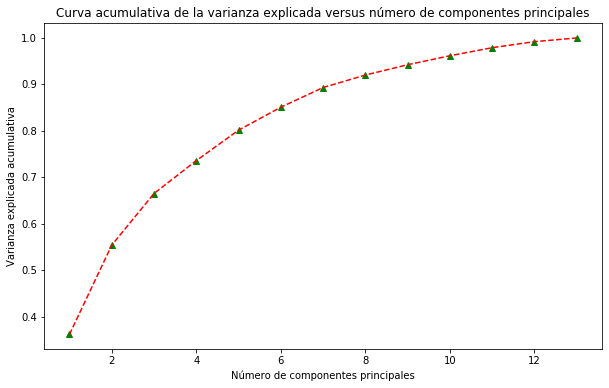

In [19]:
cum_var_exp = np.cumsum(varianza_expl)
plt.figure(figsize = (10, 6))
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulativa')
plt.title('Curva acumulativa de la varianza explicada versus número de componentes principales')
nc = np.arange(1, varianza_expl.shape[0] + 1)
plt.plot(nc, cum_var_exp, 'g^')
plt.plot(nc, cum_var_exp, '--r')
plt.show()

Podemos usar los dos componentes principales para visualizar el conjunto de datos en 2D. Para hacer esto usamos el comando *sklearn_pca.fit_transform* el cual, simultaneamente, calcula los componentes principales y transforma los datos originales proyectándolos sobre estos:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


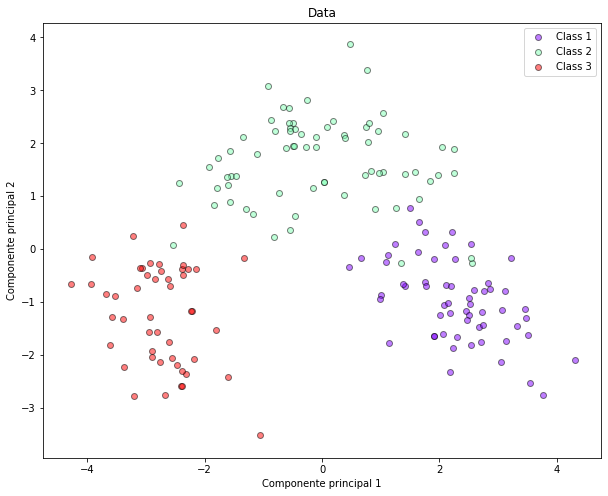

In [20]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

sklearn_pca = PCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(X_scaled)
plt.figure(figsize = (10, 8))
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Vectores singulares más significativos después de la transformación lineal a través de PCA')
plot_data(sklearn_transf,labels)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


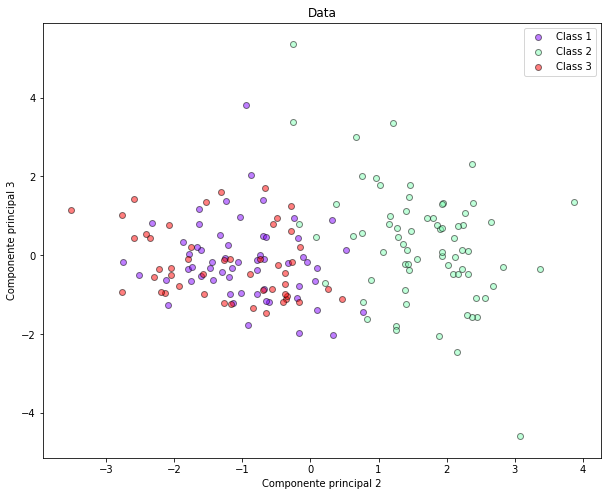

In [21]:
sklearn_pca = PCA(n_components=3)
sklearn_transf = sklearn_pca.fit_transform(X_scaled)
plt.figure(figsize = (10, 8))
plt.xlabel('Componente principal 2')
plt.ylabel('Componente principal 3')
plt.title('Vectores singulares más significativos después de la transformación lineal a través de PCA')
plot_data(sklearn_transf[:,1:3],labels)

#Aprendizaje de la representación

En esta parte trabajaremos con una muestra del conjunto de imágenes de Mnist que contiene 1500 imágenes de digitos escritos a mano. Aplicaremos reducción de dimensionalidad y evaluaremos esta herramientas en tareas de clasificación.

In [22]:
mnist = pd.read_csv("mnist1.5k.csv",  header=None).values
d=mnist[:,1:785]
c=mnist[:,0]
print("Dimensión de las imagenes y las clases: ", d.shape, c.shape)

Dimensión de las imagenes y las clases:  (1500, 784) (1500,)


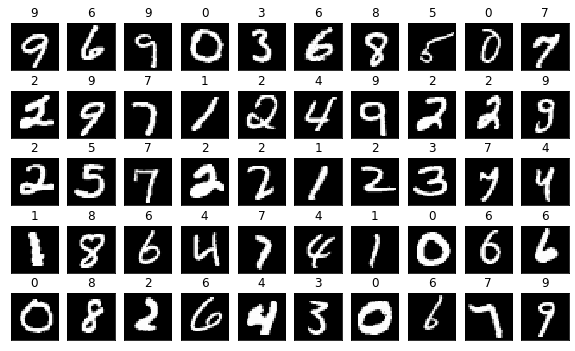

In [23]:
perm = np.random.permutation(range(d.shape[0]))[0:50]
random_imgs   = d[perm]
random_labels = c[perm] 
fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    plt.xticks([]); plt.yticks([])
    #ax.set_xticklabels([])
    #ax.set_yticklabels([])

## Aplicando análisis de las primeras 60 componentes principales

In [0]:
X=mnist[:,1:785]
y=mnist[:,0]


A continuación graficamos la curva acumulativa de la varianza explicada versus el número de componentes principales, donde podemos observar lo siguiente:
  * Las 10 primeras componentes principales representan el 49,2% de la varianza de los datos
  * Las 60 primeras componentes principales representan el 86,2% de la varianza de los datos
  * Las 100 primeras componentes principales representan el 92,3% de la varianza de los datos

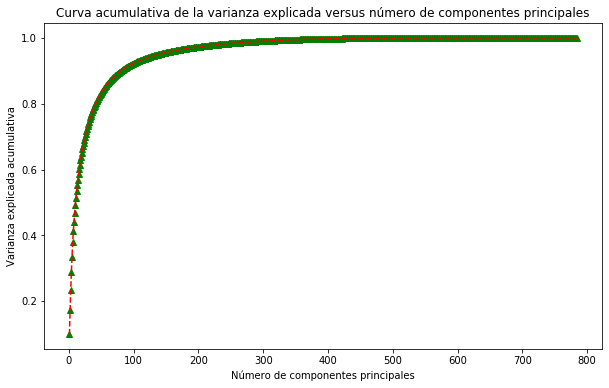

0.49288343876428853 0.8618011213919716 0.9230214472633832


In [25]:
sklearn_pca = PCA(n_components=None)
sklearn_transf = sklearn_pca.fit_transform(X)
varianza_expl = sklearn_pca.explained_variance_ratio_
varianza_expl

cum_var_exp = np.cumsum(varianza_expl)
plt.figure(figsize = (10, 6))
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulativa')
plt.title('Curva acumulativa de la varianza explicada versus número de componentes principales')
nc = np.arange(1, varianza_expl.shape[0] + 1)
plt.plot(nc, cum_var_exp, 'g^')
plt.plot(nc, cum_var_exp, '--r')
plt.show()
print(np.sum(varianza_expl[0:10]), np.sum(varianza_expl[0:60]), np.sum(varianza_expl[0:100]))

A continuación usamos las primeras 10 componentes principales:

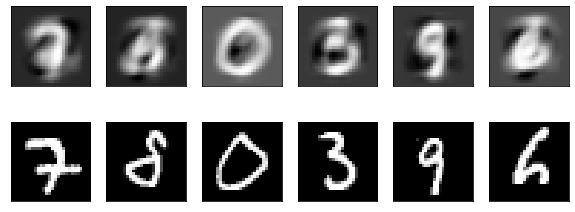

In [26]:
pca = PCA(n_components=10)
Xp = pca.fit_transform(X)
Xr = pca.inverse_transform(Xp)
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow(Xr[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

A continuación usamos las primeras 60 componentes principales:

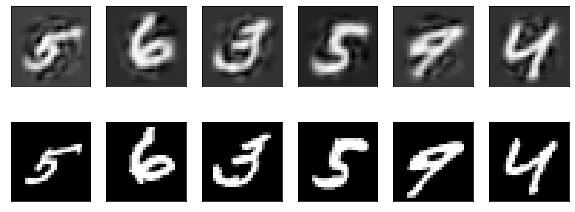

In [27]:
pca = PCA(n_components=60)
Xp = pca.fit_transform(X)
Xr = pca.inverse_transform(Xp)
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow(Xr[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

A continuación usamos las primeras 100 componentes principales:

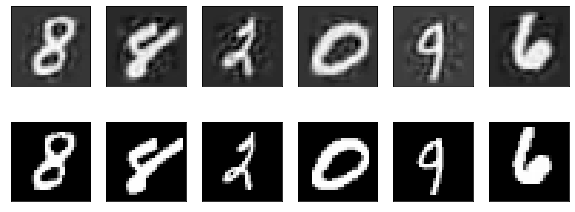

In [28]:
pca = PCA(n_components=100)
Xp = pca.fit_transform(X)
Xr = pca.inverse_transform(Xp)
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(3,6,i+1)
    k = np.random.randint(len(X))
    plt.imshow(Xr[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])
    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

### Clasificación en el nuevo espacio de representación

In [30]:
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

print("Accuracy con datos originales:", np.mean(cross_val_score(GaussianNB(), X, y, cv=5)))
print("Accuracy con nueva representación:", np.mean(cross_val_score(GaussianNB(), Xp, y, cv=5)))

Accuracy con datos originales: 0.5919753397822902
Accuracy con nueva representación: 0.8300951966057187


### Observa la nueva representación de la primera imagen

In [0]:
Xp[0]

array([-630.21531395,  730.97102722, -103.80033467,  -96.7497273 ,
       -147.33798967, -469.2616066 , -411.86646204, -603.64390064,
        163.46362004, -244.03474877, -264.69116023,   -7.50386611,
        -93.39733893, -315.31425827,  299.18100855,   43.28682583,
        -14.6626815 ,  373.48418208,  173.24426646,  -69.40952901,
         87.64641692, -271.78019408,   32.24916859,   -2.67164737,
        146.24862874, -194.55637337,   -6.74675945, -130.7010435 ,
        279.14502264,  -79.75094821,  -44.82457227,  112.90050327,
         23.96204563,  172.10174012,  113.20285368, -136.89710464,
       -102.94772611,   14.84794987, -243.59746219,   85.8183125 ,
         53.50232945,   -6.14708002, -127.35869466,  161.3861893 ,
         57.76607218,  -46.84579396,   25.35383254,   44.02714417,
       -114.69471841,   22.70488825,  110.22903296,  -74.92303656,
        128.0435822 ,   14.019337  , -109.94949853,   14.29601166,
         67.83069126,   86.69905329,   53.1870143 ,    9.31248

# Demostración

## Reducción de dimensionalidad y agrupamiento 
1. A continuación vamos a cargar el conjunto de datos de movimientos en la bolsa que está en la ubicación `data/company-stock-movements-2010-2015-incl.csv.gz`
2. Convertimos todos los valores en 1 si > 0 y -1 en otro caso
3. Aplicamos PCA con 2 componentes al conjunto de datos recién modificado (con +1/-1)
4. Graficamos la curva acumulativa de la varianza explicada versus el número de componentes principales.
    * Cuantos componentes son suficientes para presentar el 70%, 80%, 90% de la varianza de los datos?
5. Usa KMeans con 7 clusters
6. Visualiza los clusters de KMeans en el plano 2D dado por PCA

La celda a continuación carga el dataset que se encuentra en google drive

In [0]:
!wget --no-check-certificate 'https://github.com/camargoj/datasets/blob/master/company-stock-movements-2010-2015-incl.csv?raw=true' -O dataset.csv

--2019-11-16 14:45:04--  https://github.com/camargoj/datasets/blob/master/company-stock-movements-2010-2015-incl.csv?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/camargoj/datasets/raw/master/company-stock-movements-2010-2015-incl.csv [following]
--2019-11-16 14:45:04--  https://github.com/camargoj/datasets/raw/master/company-stock-movements-2010-2015-incl.csv
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/camargoj/datasets/master/company-stock-movements-2010-2015-incl.csv [following]
--2019-11-16 14:45:05--  https://raw.githubusercontent.com/camargoj/datasets/master/company-stock-movements-2010-2015-incl.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecti

In [0]:
#!ls -la
from sklearn.decomposition import PCA
d = pd.read_csv("dataset.csv", index_col=0)

In [0]:
d.head(4)

,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,2010-01-19,2010-01-20,2010-01-21,2010-01-22,2010-01-25,2010-01-26,2010-01-27,2010-01-28,2010-01-29,2010-02-01,2010-02-02,2010-02-03,2010-02-04,2010-02-05,2010-02-08,2010-02-09,2010-02-10,2010-02-11,2010-02-12,2010-02-16,2010-02-17,2010-02-18,2010-02-19,2010-02-22,2010-02-23,2010-02-24,2010-02-25,2010-02-26,2010-03-01,2010-03-02,...,2013-09-04,2013-09-05,2013-09-06,2013-09-09,2013-09-10,2013-09-11,2013-09-12,2013-09-13,2013-09-16,2013-09-17,2013-09-18,2013-09-19,2013-09-20,2013-09-23,2013-09-24,2013-09-25,2013-09-26,2013-09-27,2013-09-30,2013-10-01,2013-10-02,2013-10-03,2013-10-04,2013-10-07,2013-10-08,2013-10-09,2013-10-10,2013-10-11,2013-10-14,2013-10-15,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
Apple,0.580000,-0.220005,-3.409998,-1.170000,1.680011,-2.689994,-1.469994,2.779997,-0.680003,-4.999995,6.709993,-3.180006,-4.009998,-9.030006,0.560000,-0.010000,1.030010,-5.640009,-9.019993,2.360001,-0.050001,4.060000,-4.680000,2.829998,-1.570009,-0.229992,-0.769990,3.789993,2.269998,1.459994,-1.639998,1.300003,-0.190005,-1.920004,-2.940000,2.430002,4.619999,2.239998,3.240008,-1.079998,...,-0.869980,-4.980034,-0.219979,1.169960,-11.559998,0.699989,4.190003,-4.439995,-10.879982,7.360008,1.500008,1.599983,-10.589988,-5.459991,-5.779999,-7.669976,0.219979,-1.029983,-0.500038,9.510018,3.929970,-7.100029,-0.829979,1.190040,-9.000045,1.950005,-1.679985,5.820000,6.209969,1.169960,0.320008,4.519997,2.899987,9.590019,-6.540016,5.959976,6.910011,-5.359962,0.840019,-19.589981
AIG,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,-0.500000,0.200001,-0.100000,-0.460001,-1.190001,-0.650000,-1.300001,0.430000,-1.690000,-0.300001,-0.420000,-0.020001,-0.099998,-0.940001,-0.090000,-0.250000,0.760000,3.710001,-0.200001,1.000000,0.000000,-0.630001,0.299999,-0.010000,1.540001,-1.459999,0.830000,0.069999,-0.900000,-2.179998,-0.899999,...,0.680000,0.229999,-0.720002,0.829998,-0.130001,0.340000,-0.620003,0.320000,-0.470001,0.790001,0.279999,-0.930000,-0.020000,-0.439998,0.100003,0.190003,-0.239998,-0.029998,0.020000,0.579998,0.350002,-0.210003,0.660000,-0.310001,-1.099998,0.050000,1.290001,0.330002,0.599999,-0.160000,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
Amazon,-2.350006,1.260009,-2.350006,-2.009995,2.960006,-2.309997,-1.640007,1.209999,-1.790001,-2.039994,1.300003,-1.349998,-0.639999,-4.169998,-1.790000,-1.079995,1.720001,1.599999,-4.360000,-4.309997,-0.669998,1.979995,-2.699997,1.510002,-2.549995,-0.169998,-0.639999,2.879997,0.670006,-2.529999,-0.760002,2.240006,-0.390007,0.639999,-0.770004,1.760002,0.029999,0.520005,5.840004,0.519997,...,5.310028,0.470001,0.529998,2.489990,-0.190003,0.730011,-0.530030,-2.220002,-3.760009,6.540008,7.970001,-1.709991,3.799987,-2.520020,1.700012,-1.880005,4.220001,-0.910003,-0.769989,6.730011,2.470001,-5.630005,3.910004,-5.209991,-8.269989,-5.190002,0.540008,6.120026,1.480011,-3.470001,2.109985,3.699982,9.570008,-3.450013,4.820008,-4.079986,2.579986,4.790009,-1.760009,3.740021
American express,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,-0.130001,0.719997,0.050000,-0.830002,-2.770001,-1.309997,0.559997,0.709999,-1.239998,0.060002,0.369999,0.340000,-0.579998,-0.500000,0.189998,-0.969997,0.270001,0.169998,0.480000,0.629997,0.809998,-0.480000,0.080002,0.170002,-0.169998,-0.810002,0.310002,0.370003,0.039997,-0.070000,0.270000,...,0.620002,0.639999,-0.570000,0.070008,0.379997,0.480003,0.000000,-0.279999,-0.739998,1.320000,0.650001,-0.239998,-0.300003,-0.849999,-0.319999,-0.139999,0.320000,-0.169999,0.549996,0.290001,-0.549995,-0.090004,0.430001,-0.559998,-0.809998,-0.159996,1.470002,0.730004,0.739998,-0.379997,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001


In [0]:
def convert(x):
  if x > 0:
    return 1
  else:
    return -1

In [0]:
vec_converter = np.vectorize(convert)

In [0]:
d_tr = d.apply(vec_converter)
d_tr.head(4)

,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,2010-01-19,2010-01-20,2010-01-21,2010-01-22,2010-01-25,2010-01-26,2010-01-27,2010-01-28,2010-01-29,2010-02-01,2010-02-02,2010-02-03,2010-02-04,2010-02-05,2010-02-08,2010-02-09,2010-02-10,2010-02-11,2010-02-12,2010-02-16,2010-02-17,2010-02-18,2010-02-19,2010-02-22,2010-02-23,2010-02-24,2010-02-25,2010-02-26,2010-03-01,2010-03-02,...,2013-09-04,2013-09-05,2013-09-06,2013-09-09,2013-09-10,2013-09-11,2013-09-12,2013-09-13,2013-09-16,2013-09-17,2013-09-18,2013-09-19,2013-09-20,2013-09-23,2013-09-24,2013-09-25,2013-09-26,2013-09-27,2013-09-30,2013-10-01,2013-10-02,2013-10-03,2013-10-04,2013-10-07,2013-10-08,2013-10-09,2013-10-10,2013-10-11,2013-10-14,2013-10-15,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
Apple,1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,1,-1,...,-1,-1,-1,1,-1,1,1,-1,-1,1,1,1,-1,-1,-1,-1,1,-1,-1,1,1,-1,-1,1,-1,1,-1,1,1,1,1,1,1,1,-1,1,1,-1,1,-1
AIG,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,1,-1,1,1,-1,-1,-1,...,1,1,-1,1,-1,1,-1,1,-1,1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,-1,1,1,1,1,-1,1,1,1,-1,1,-1,-1,-1,-1,1
Amazon,-1,1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,1,1,-1,-1,-1,1,-1,1,-1,-1,-1,1,1,-1,-1,1,-1,1,-1,1,1,1,1,1,...,1,1,1,1,-1,1,-1,-1,-1,1,1,-1,1,-1,1,-1,1,-1,-1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1,1,1,-1,1,-1,1,1,-1,1
American express,1,-1,1,1,1,-1,1,1,1,-1,1,1,-1,-1,-1,1,1,-1,1,1,1,-1,-1,1,-1,1,1,1,1,1,-1,1,1,-1,-1,1,1,1,-1,1,...,1,1,-1,1,1,1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,1,-1,1,1,-1,-1,1,-1,-1,-1,1,1,1,-1,1,1,1,-1,1,1,1,1,1,1


In [0]:
sklearn_pca = PCA(n_components=2)
X = sklearn_pca.fit_transform(d_tr.values)
X.shape

(60, 2)

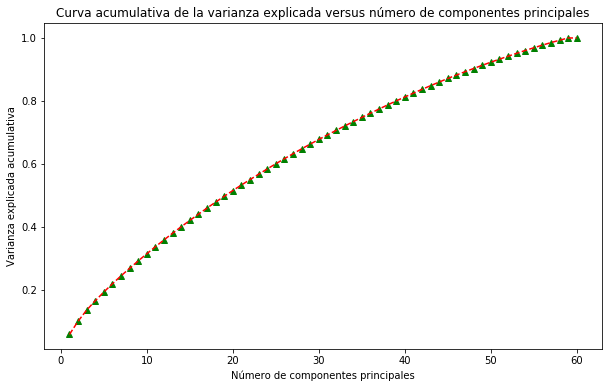

0.3147382418643751 0.51538060533334 0.9999999999999998


In [0]:
pca = PCA(n_components=None)
pca.fit_transform(d_tr.values)
varianza_expl = pca.explained_variance_ratio_
varianza_expl

cum_var_exp = np.cumsum(varianza_expl)
plt.figure(figsize = (10, 6))
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulativa')
plt.title('Curva acumulativa de la varianza explicada versus número de componentes principales')
nc = np.arange(1, varianza_expl.shape[0] + 1)
plt.plot(nc, cum_var_exp, 'g^')
plt.plot(nc, cum_var_exp, '--r')
plt.show()
print(np.sum(varianza_expl[0:10]), np.sum(varianza_expl[0:20]), np.sum(varianza_expl[0:60]))

In [0]:
from sklearn.cluster import KMeans

In [0]:
n_clusters = 7

y = KMeans(n_clusters=n_clusters).fit_predict(X)
y.shape

(60,)

Verifica tu código. Debe de aparecer aproximadamente como esto:

![Imagen acciones](https://i.imgur.com/8f2LgxK.png)

**Código de ayuda para imprimir un texto al lado de cada punto en el plano 2D**:

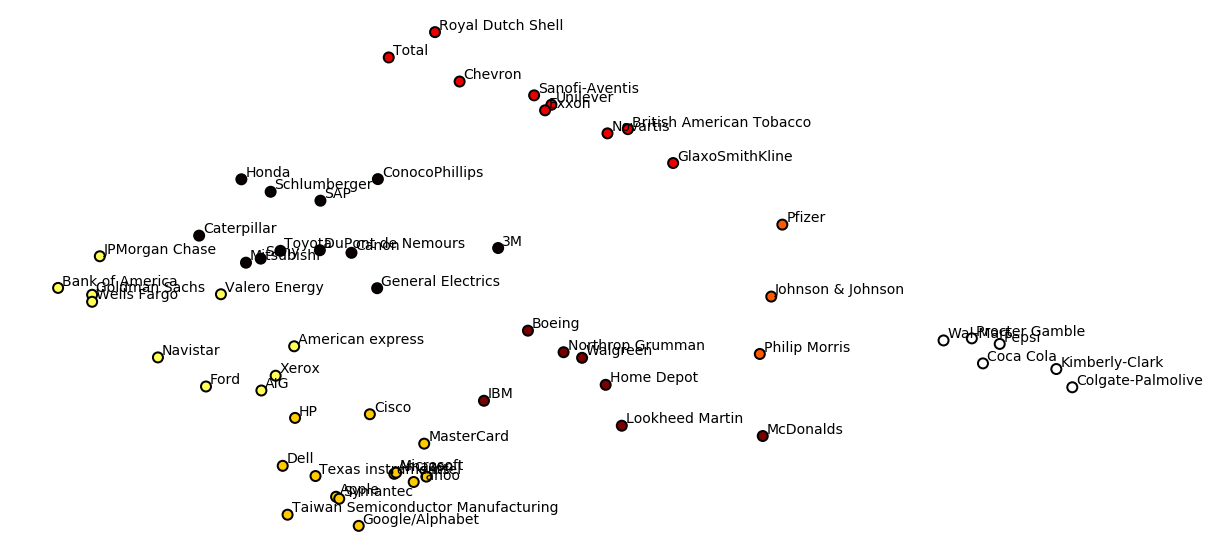

In [0]:
cmap = plt.cm.hot
plt.figure(figsize=(20,10))
plt.scatter(X[:,0], X[:,1], color=cmap((y*255./(n_clusters-1)).astype(int)), s=100, edgecolor="black", lw=2)
for i in range(len(d)):
    name = d.index[i]
    plt.text(X[i,0]+.1, X[i,1]+.1, d.index[i], fontsize=14)
plt.axis("off");

## Reducción de dimensionalidad para conjunto de imágenes de rostros
  1. A continuación vamos a cargar el conjunto de imágenes de rostros que está en la ubicación `data/faces.pkl`
  2. Graficamos la curva acumulativa de la varianza explicada versus el número de componentes principales.
    * ¿Cuántos componentes son suficientes para presentar el 70%, 80%, 90% de la varianza de los datos?
  3. Reconstruya las imágenes de rostro con el número de componentes del 70%, 80% y 90% de la varianza 
  

**Código de ayuda para cargar la base de datos, despues de haber sido descargada con wget**:

In [0]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1y4rB16HEdEPV3WtBUFbpLQGPtrEMNrox' -O faces.pkl

--2019-11-16 12:39:35--  https://docs.google.com/uc?export=download&id=1y4rB16HEdEPV3WtBUFbpLQGPtrEMNrox
Resolving docs.google.com (docs.google.com)... 108.177.127.101, 108.177.127.113, 108.177.127.100, ...
Connecting to docs.google.com (docs.google.com)|108.177.127.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/56afa9435d65sabjajp1moh6f6qh4bbh/1573905600000/13121894196654599000/*/1y4rB16HEdEPV3WtBUFbpLQGPtrEMNrox?e=download [following]
--2019-11-16 12:39:35--  https://doc-04-2c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/56afa9435d65sabjajp1moh6f6qh4bbh/1573905600000/13121894196654599000/*/1y4rB16HEdEPV3WtBUFbpLQGPtrEMNrox?e=download
Resolving doc-04-2c-docs.googleusercontent.com (doc-04-2c-docs.googleusercontent.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to doc-04-2c-docs.googleusercontent.com (doc-04

In [0]:
import pickle
faces = pickle.load(open("faces.pkl", "rb"), encoding='latin1')
faces.shape

(535, 361)

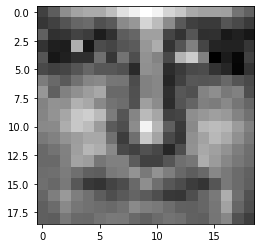

In [0]:
# Show faces 
plt.imshow(np.abs(faces[0]).reshape((19,19)), cmap="gray")

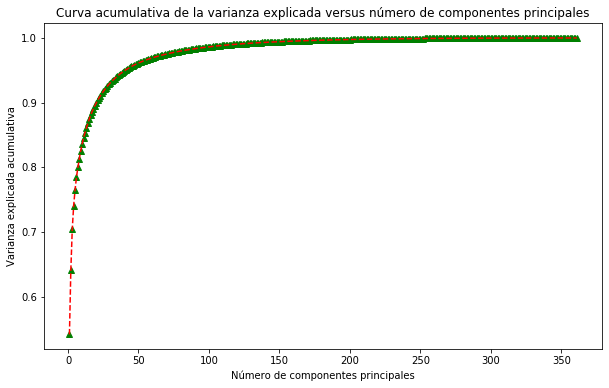

0.8360191379770135 0.9694738802606884 0.98629404179837


In [0]:
sklearn_pca = PCA(n_components=None)
sklearn_transf = sklearn_pca.fit_transform(faces)
varianza_expl = sklearn_pca.explained_variance_ratio_
varianza_expl

cum_var_exp = np.cumsum(varianza_expl)
plt.figure(figsize = (10, 6))
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulativa')
plt.title('Curva acumulativa de la varianza explicada versus número de componentes principales')
nc = np.arange(1, varianza_expl.shape[0] + 1)
plt.plot(nc, cum_var_exp, 'g^')
plt.plot(nc, cum_var_exp, '--r')
plt.show()
print(np.sum(varianza_expl[0:10]), np.sum(varianza_expl[0:60]), np.sum(varianza_expl[0:100]))

In [0]:
print("n_components to explain 70% of variance: {}".format(np.sum(np.cumsum(varianza_expl)<=0.7)))
print("n_components to explain 80% of variance: {}".format(np.sum(np.cumsum(varianza_expl)<=0.8)))
print("n_components to explain 90% of variance: {}".format(np.sum(np.cumsum(varianza_expl)<=0.9)))

n_components to explain 70% of variance: 2
n_components to explain 80% of variance: 7
n_components to explain 90% of variance: 20


In [0]:
from sklearn.metrics import mean_squared_error

Error de reconstrucción con 2 componentes: 672.3270918802792
Error de reconstrucción con 7 componentes: 375.63061741161613
Error de reconstrucción con 20 componentes: 188.4667590717133


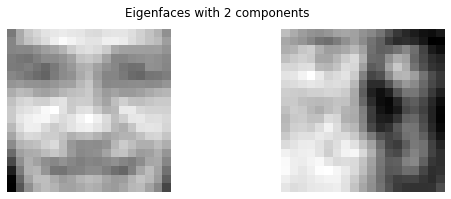

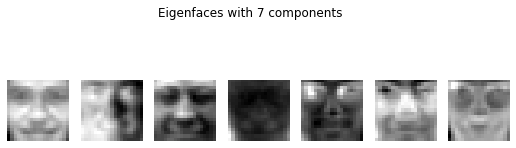

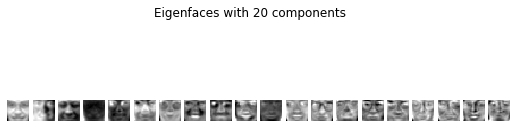

In [0]:
# reconstruimos con distinto número de componentes
for n in [2,7, 20]:
  pca = PCA(n_components=n)
  X_tr = pca.fit_transform(faces)
  # print reconstruction error 
  print("Error de reconstrucción con {} componentes: {}".format(n, mean_squared_error(faces, pca.inverse_transform(X_tr))))
  # print reducced faces 
  fig, axes = plt.subplots(1,n,figsize=(9,3))
  fig.suptitle("Eigenfaces with {} components".format(n))
  for i in range(0,n):
    axes[i].imshow(pca.components_[i].reshape(19,19), cmap="gray")
    axes[i].axis("off")
    fig.show()